## Surrogate Assisted Evolutionary Algorithms for CNN Hyperparameter Optimization

### Imports

In [1]:
from util import AlexNet, SmallCNN, get_loaders, train_model

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm
import pickle
import os
import torch

### CNN Hyperparameters

In [ ]:
# CNN Hyperparameters
DATA_DIR = '~/data'
DATASET = 'cifar'
BATCH_SIZE = 128
NUM_CLASSES = 10
NUM_EPOCHS = 10
VALIDATION_TARGET = 100 # target validation accuracy
TRAIN_CONCURRENT = 5 # number of models to train concurrently
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load data

In [ ]:
# Get dataloaders
train_loader, valid_loader = get_loaders(data_dir=DATA_DIR, dataset=DATASET, batch_size=BATCH_SIZE, download=False)
model = SmallCNN().to(DEVICE)

# SGD optimizer - momentum, weight decay are the hyperparameters we are optimizing
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

In [ ]:
# Train model
log_dict = train_model(model=model, 
                num_epochs=NUM_EPOCHS, 
                optimizer=optimizer, 
                device=DEVICE, 
                train_loader=train_loader, 
                valid_loader=valid_loader,
                valid_target=VALIDATION_TARGET,
                print_=True)

# Calculate fitness as a function of validation accuracy and number of batches trained
valid_acc = log_dict['valid_acc_per_epoch'][-1]
train_acc = log_dict['train_acc_per_epoch'][-1]
num_epochs_trained = log_dict['num_epochs_trained']

In [ ]:
# plot training curves
plt.plot(log_dict['train_acc_per_epoch'], label='train_acc_per_epoch')
plt.plot(log_dict['valid_acc_per_epoch'], label='valid_acc_per_epoch')
plt.legend()
plt.show()


# create running average of loss per batch
avg_loss = []
for i in range(len(log_dict['train_loss_per_batch'])):
    avg_loss.append(np.mean(log_dict['train_loss_per_batch'][i-100:i+100]))

# plot loss per batch
plt.plot(log_dict['train_loss_per_batch'], label='train_loss_per_batch')
plt.plot(avg_loss, label='running_avg')
plt.legend()
plt.show()

In [ ]:
loss_threshold = .5

# number of batches trained
print('Number of batches trained: {}'.format(len(log_dict['train_loss_per_batch'])))

# find batch where training loss is less than loss_threshold
for i, acc in enumerate(log_dict['train_loss_per_batch']):
    if acc < loss_threshold :
        break

tt_score = (1 - ((i+1) / len(log_dict['train_loss_per_batch'])))*100
print('Training loss first falls below {} at batch {}'.format(loss_threshold, tt_score))

In [2]:
from es import *

# Initialize population creation
population = [Genome() for _ in range(100)]

# Update fitnesses using multiprocessing   
x_values = [genome.x for genome in population]
with ProcessPoolExecutor(TRAIN_CONCURRENT) as executor:
    results = list(tqdm(executor.map(fitness, population), total=len(population)))


100%|██████████| 100/100 [1:17:13<00:00, 46.33s/it]


In [3]:
for i in range(len(population)):
    population[i].valid_acc = results[i][0]
    population[i].train_acc = results[i][1]
    population[i].train_loss = results[i][2]
    population[i].loss_target_fitness = results[i][3]


In [4]:
# mean population validation accuracy
mean_valid_acc = np.mean([genome.valid_acc for genome in population])
print('Mean population validation accuracy: {}'.format(mean_valid_acc))

# mean population training accuracy
mean_train_acc = np.mean([genome.train_acc for genome in population])
print('Mean population training accuracy: {}'.format(mean_train_acc))

# mean population training loss
mean_train_loss = np.mean([genome.train_loss for genome in population])
print('Mean population training loss: {}'.format(mean_train_loss))

# mean population loss target fitness
mean_loss_target_fitness = np.mean([genome.loss_target_fitness for genome in population])
print('Mean population loss target fitness: {}'.format(mean_loss_target_fitness))

# max population validation accuracy
max_valid_acc = np.max([genome.valid_acc for genome in population])
print('Max population validation accuracy: {}'.format(max_valid_acc))

# max population training accuracy
max_train_acc = np.max([genome.train_acc for genome in population])
print('Max population training accuracy: {}'.format(max_train_acc))

# max population training loss
max_train_loss = np.max([genome.train_loss for genome in population])
print('Max population training loss: {}'.format(max_train_loss))

# max population loss target fitness
max_loss_target_fitness = np.max([genome.loss_target_fitness for genome in population])
print('Max population loss target fitness: {}'.format(max_loss_target_fitness))


Mean population validation accuracy: 31.11579918861389
Mean population training accuracy: 32.075359191894535
Mean population training loss: 1.4122305783629416
Mean population loss target fitness: 27.82199488491048
Max population validation accuracy: 62.94999694824219
Max population training accuracy: 72.35199737548828
Max population training loss: 2.327260732650757
Max population loss target fitness: 91.71355498721228


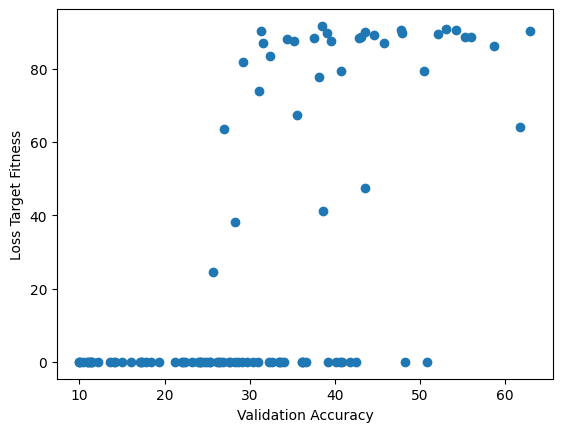

In [5]:
# plot validation accuracy vs loss target fitness

plt.scatter([genome.valid_acc for genome in population], [genome.loss_target_fitness for genome in population])
plt.xlabel('Validation Accuracy')
plt.ylabel('Loss Target Fitness')
plt.show()


In [6]:
import oapackage

pareto=oapackage.ParetoDoubleLong()

for ii in range(0, len(population)):
    w=oapackage.doubleVector( (population[ii].valid_acc, population[ii].loss_target_fitness))
    pareto.addvalue(w, ii)

pareto.show(verbose=1)


Pareto: 4 optimal values, 4 objects


In [8]:
# save results to pickle file
with open('training_population.pkl', 'wb') as f:
    pickle.dump(population, f)


In [9]:
# open results from pickle file
with open('training_population.pkl', 'rb') as f:
    training_population = pickle.load(f)
